In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline

# Get mapbox API key (this won't work, since I did not submit the .env file.)
# If you would like to see this in action, get your own API key from mapbox.com or remove the bottom two lines of code.
from dotenv import dotenv_values
mapbox_access_token = dotenv_values(".env")['MAPBOX_API']

### Objective 1: 
To investigate the bus system with a focus on identifying capacity (dispatch) and demand (ridership) patterns in Singapore.

In [2]:
# Read the data
bus = pd.read_csv('./data/bus_demand_and_capacity.csv')
bus_demand = pd.read_csv('./data/bus_demand_high_LOD.csv')
bus_stops = pd.read_csv('./datasrc/bus_stops.csv')

In [3]:
display(bus[bus['ServiceNo']=='991A'])

ServiceNo  Direction  StopSequence Operator  BusStopCode  Distance  \
25869      991A          1             1     SMRT        43009       0.0   
25870      991A          1             2     SMRT        43419       0.4   
25871      991A          1             3     SMRT        43401       0.8   
25872      991A          1             4     SMRT        43321       1.2   
25873      991A          1             5     SMRT        43331       1.5   
25874      991A          1             6     SMRT        43341       1.8   

                  RoadName             Description  Latitude   Longitude  ...  \
25869        Bt Batok Ctrl            Bt Batok Int  1.349994  103.751062  ...   
25870        Bt Batok Ctrl                 Blk 628  1.351555  103.749988  ...   
25871  Bt Batok West Ave 3     Bt Batok Polyclinic  1.352265  103.746816  ...   
25872  Bt Batok West Ave 6             Opp Blk 144  1.349906  103.745109  ...   
25873       Bt Batok St 11  Opp Bt Batok Presby Ch  1.348939  103.743234  ...   
25874  Bt Batok West Ave 3       Princess E Pr Sch  1.349722  103.741393  ...   

      Weekday_Monthly_TapIn_PM_Offpeak  Weekend/Hols_Monthly_TapIn_PM_Offpeak  \
25869                            847.0                                 1181.0   
25870                           1373.0                                  601.0   
25871                            276.0                                  110.0   
25872                            216.0                                   80.0   
25873                            214.0                                   76.0   
25874                            328.0                                  135.0   

       Weekday_Monthly_TapOut_AM_Peak Weekend/Hols_Monthly_TapOut_AM_Peak  \
25869                             0.0                              2452.0   
25870                             0.0                               905.0   
25871                          1410.0                               273.0   
25872                           641.0                               267.0   
25873                           691.0                               240.0   
25874                          1079.0                               126.0   

       Weekday_Monthly_TapOut_AM_Offpeak  \
25869                                0.0   
25870                             2445.0   
25871                             1246.0   
25872                              647.0   
25873                              741.0   
25874                              585.0   

       Weekend/Hols_Monthly_TapOut_AM_Offpeak  Weekday_Monthly_TapOut_PM_Peak  \
25869                                     0.0                             0.0   
25870                                  1368.0                             0.0   
25871                                   354.0                          1157.0   
25872                                   311.0                           875.0   
25873                                   340.0                          1335.0   
25874                                   208.0                           825.0   

       Weekend/Hols_Monthly_TapOut_PM_Peak  Weekday_Monthly_TapOut_PM_Offpeak  \
25869                                  0.0                              377.0   
25870                               1477.0                              904.0   
25871                                341.0                              434.0   
25872                                270.0                              277.0   
25873                                360.0                              348.0   
25874                                214.0                              299.0   

       Weekend/Hols_Monthly_TapOut_PM_Offpeak  
25869                                   561.0  
25870                                   452.0  
25871                                   182.0  
25872                                   124.0  
25873                                   129.0  
25874                                   127.0  

[6 rows x 34 co

In [4]:
print(bus['Category'].unique())


['TRUNK' 'EXPRESS' 'NIGHT SERVICE' 'FEEDER' 'INDUSTRIAL' 'TOWNLINK'
 'FLAT FARE $2.70' 'FLAT FARE $3.50' 'FLAT FARE $5.00' 'FLAT FARE $4.20'
 'FLAT FARE $4.50' 'FLAT FARE $4.00' 'CITY_LINK' 'FLAT FARE $2.00'
 'NIGHT RIDER']


In [5]:
# Get bus with category of Trunk,Express,Feeder drop everything else
bus = bus[bus['Category'].isin(['TRUNK','EXPRESS','FEEDER'])]


### Chart 1
Violin Plot of number of bus dispatched at different times of the day

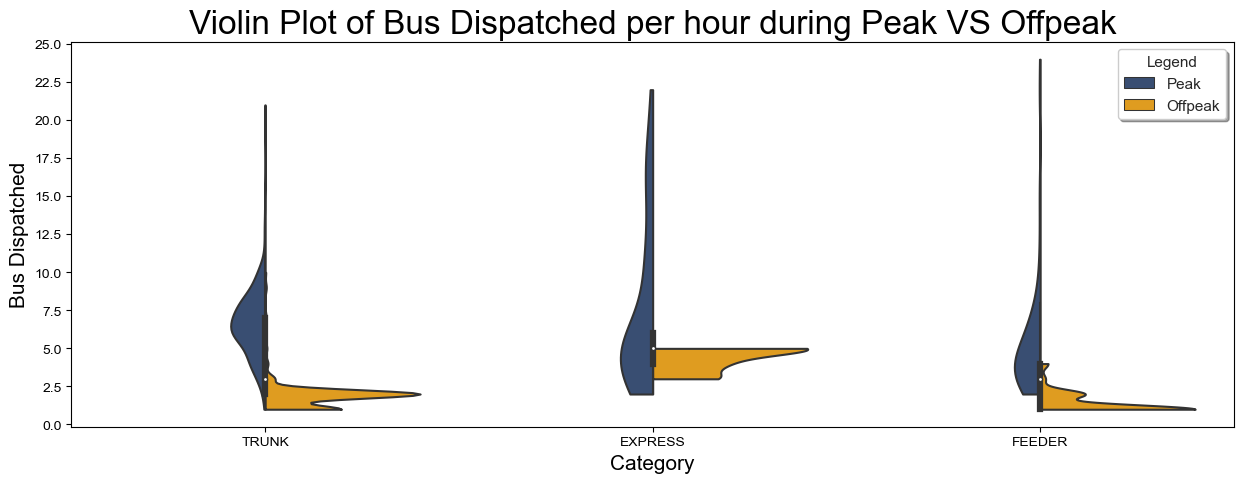

In [6]:
df = bus.copy()

# Group by routes
df = df.groupby(['ServiceNo','Direction']).agg({'AM_Peak_avg':'mean','PM_Peak_avg':'mean','AM_Offpeak_avg':'mean','PM_Offpeak_avg':'mean', 'Category':'first'}).reset_index()

# Convert it to bus dispatched per hour instead of total bus dispatched
df['Peak_Dispatch'] = (df['AM_Peak_avg'] + df['PM_Peak_avg'])//(3)
df['Offpeak_Dispatch'] = (df['AM_Offpeak_avg'] + df['PM_Offpeak_avg'])//(11)

df = df[['ServiceNo','Direction','Category','Peak_Dispatch','Offpeak_Dispatch']]

# Dropna
df = df.dropna()

# Convert from wide to long
df = pd.melt(df, id_vars=['ServiceNo','Direction','Category'], value_vars=['Peak_Dispatch','Offpeak_Dispatch'], var_name='Peak', value_name='Dispatch')
# Drop all 0
df = df[df['Dispatch']!=0]

# Plot Graph
fig, ax = plt.subplots(figsize=(15,5))

sns.violinplot(x='Category', y='Dispatch', data=df, hue='Peak', cut=0, split=True, palette=sns.color_palette(["#2f4b7c", "#ffa600"]), ax=ax)

# Edit the style
sns.set(style="darkgrid", rc={'figure.facecolor':'lightblue'}, font_scale=1.2)

# Edit the legend
ax.legend(loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')

# Edit legend values
ax.get_legend().get_texts()[0].set_text('Peak')
ax.get_legend().get_texts()[1].set_text('Offpeak')

# Edit x and y labels
ax.set_xlabel('Category', fontsize=15)
ax.set_ylabel('Bus Dispatched', fontsize=15)

# Edit y axis
ax.set_yticks(np.arange(0, 26, 2.5))

# Edit the title
ax.set_title('Violin Plot of Bus Dispatched per hour during Peak VS Offpeak', fontsize=24)

# Offpeak not lot of bus for express and feeder (with 0 being the mode)
# This suggest that express and feeder are not dispatched as much during offpeak

plt.show()

### Chart 2
Reg Plot during different time (AM Peak, PM Peak, AM Offpeak, PM Offpeak) between total number of ridership per route (sum of tap in) and number of bus dispatched

In [7]:
df = bus.copy()

# Get Mean Bus Dispatched per Route
category = df.groupby(['ServiceNo','Direction']).agg({'Category':'first', 'AM_Peak_avg' : 'mean', 'PM_Peak_avg' : 'mean', 'AM_Offpeak_avg' : 'mean', 'PM_Offpeak_avg' : 'mean'}).reset_index()

# Change column name of distance to distance per route
category = category.rename(columns={'AM_Peak_avg':'AM_Peak_Dispatch', 'PM_Peak_avg':'PM_Peak_Dispatch', 'AM_Offpeak_avg':'AM_Offpeak_Dispatch', 'PM_Offpeak_avg':'PM_Offpeak_Dispatch'})

df = df.groupby(['ServiceNo','Direction']).sum().reset_index()
df = df.merge(category, on=['ServiceNo','Direction'])
df = df.dropna()

# Reformat data
df['Weekday_Peak_Tap_In'] = (df['Weekday_Monthly_TapIn_AM_Peak'] + df['Weekday_Monthly_TapIn_PM_Peak'])
df['Weekday_Offpeak_Tap_In'] = (df['Weekday_Monthly_TapIn_AM_Offpeak'] + df['Weekday_Monthly_TapIn_PM_Offpeak'])
df['Weekend_Peak_Tap_In'] = (df['Weekend/Hols_Monthly_TapIn_AM_Peak'] + df['Weekend/Hols_Monthly_TapIn_PM_Peak'])
df['Weekend_Offpeak_Tap_In'] = (df['Weekend/Hols_Monthly_TapIn_AM_Offpeak'] + df['Weekend/Hols_Monthly_TapIn_PM_Offpeak'])

df['Peak_Dispatch'] = (df['AM_Peak_Dispatch'] + df['PM_Peak_Dispatch'])//2
df['Offpeak_Dispatch'] = (df['AM_Offpeak_Dispatch'] + df['PM_Offpeak_Dispatch'])//8

df = df[['ServiceNo','Direction','Category','Peak_Dispatch','Offpeak_Dispatch','Weekday_Peak_Tap_In','Weekday_Offpeak_Tap_In','Weekend_Peak_Tap_In','Weekend_Offpeak_Tap_In']]

# Remove outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR
df = df[(df >= left) & (df <= right)]

C:\Users\ryany\AppData\Local\Temp\ipykernel_37316\106328348.py:30: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[(df >= left) & (df <= right)]


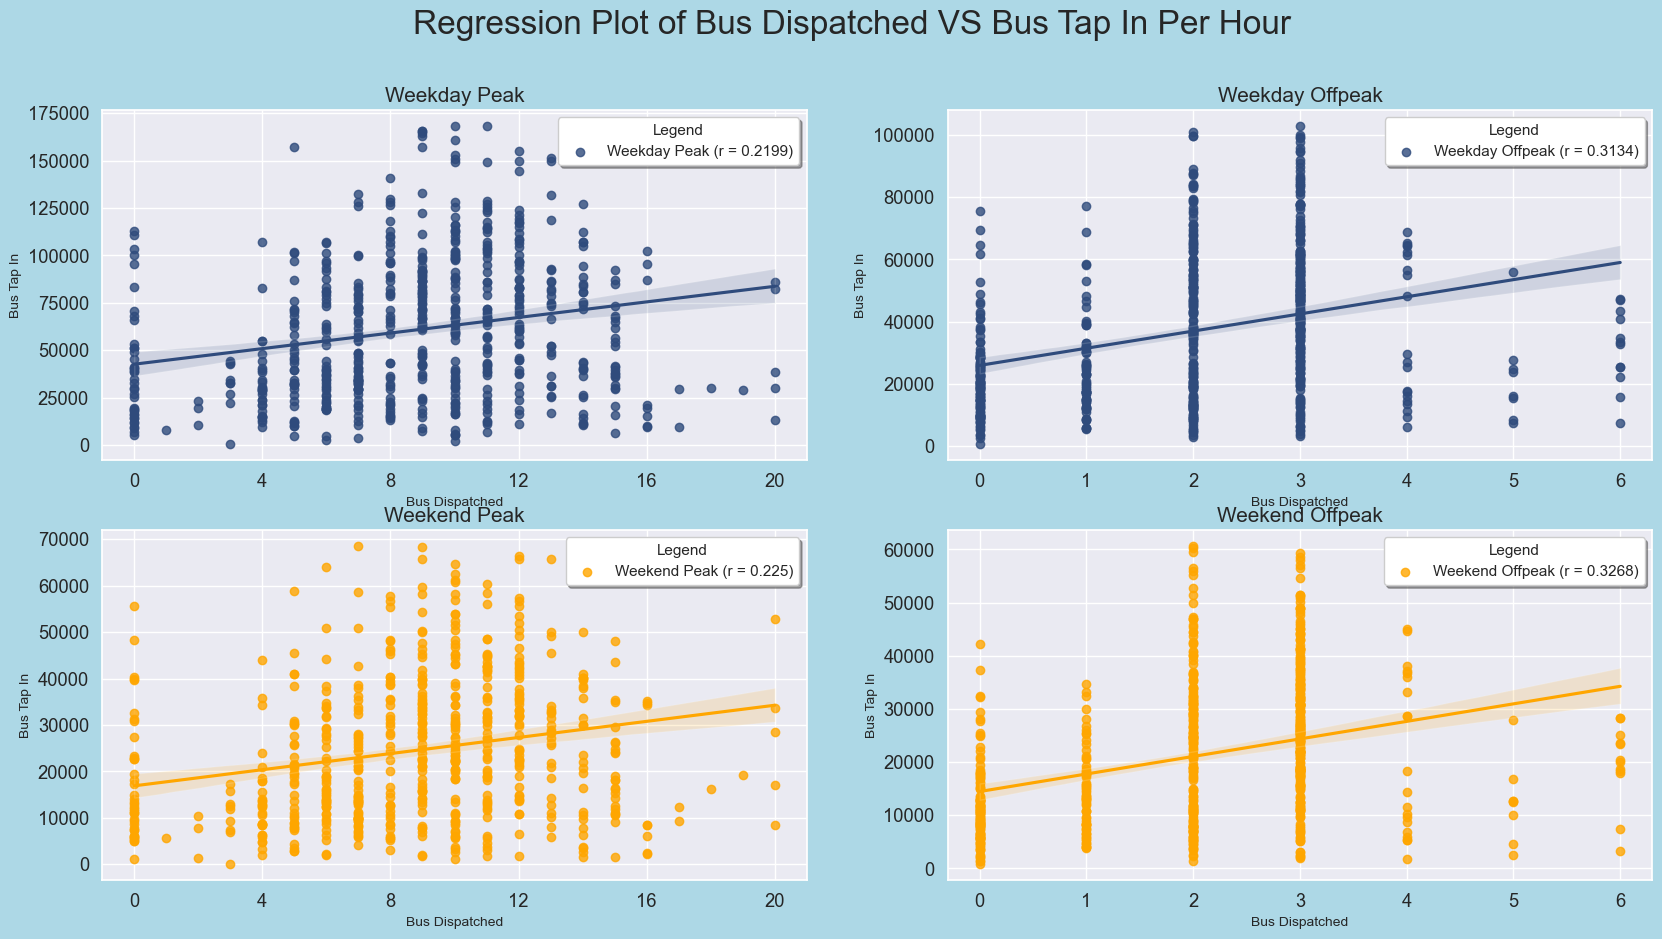

In [8]:
# Plot Four Regression Plots in Seaborn
fig, ax = plt.subplots(2,2, figsize=(20,10))

# Weekday Peak
sns.regplot(x='Peak_Dispatch', y='Weekday_Peak_Tap_In', data=df, ax=ax[0,0], color='#2f4b7c')
ax[0,0].set_title('Weekday Peak', fontsize=15)
ax[0,0].set_xlabel('Bus Dispatched', fontsize=10)
ax[0,0].set_ylabel('Bus Tap In', fontsize=10)
ax[0,0].set_xticks(np.arange(0, 21,4))

# Weekday Offpeak
sns.regplot(x='Offpeak_Dispatch', y='Weekday_Offpeak_Tap_In', data=df, ax=ax[0,1], color='#2f4b7c')
ax[0,1].set_title('Weekday Offpeak', fontsize=15)
ax[0,1].set_xlabel('Bus Dispatched', fontsize=10)
ax[0,1].set_ylabel('Bus Tap In', fontsize=10)

# Weekend Peak
sns.regplot(x='Peak_Dispatch', y='Weekend_Peak_Tap_In', data=df, ax=ax[1,0], color='#ffa600')
ax[1,0].set_title('Weekend Peak', fontsize=15)
ax[1,0].set_xlabel('Bus Dispatched', fontsize=10)
ax[1,0].set_ylabel('Bus Tap In', fontsize=10)
ax[1,0].set_xticks(np.arange(0, 21,4))

# Weekend Offpeak
sns.regplot(x='Offpeak_Dispatch', y='Weekend_Offpeak_Tap_In', data=df, ax=ax[1,1], color='#ffa600')
ax[1,1].set_title('Weekend Offpeak', fontsize=15)
ax[1,1].set_xlabel('Bus Dispatched', fontsize=10)
ax[1,1].set_ylabel('Bus Tap In', fontsize=10)

# Edit the style
sns.set(style="darkgrid", rc={'figure.facecolor':'lightblue'}, font_scale=1.2)

# Add overall title
fig.suptitle('Regression Plot of Bus Dispatched VS Bus Tap In Per Hour', fontsize=24)

# Add legend for each subplot
ax[0,0].legend(['Weekday Peak'], loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')
# Include r-value
ax[0,0].get_legend().get_texts()[0].set_text(f'Weekday Peak (r = {round(df["Weekday_Peak_Tap_In"].corr(df["Peak_Dispatch"]),4)})')

ax[0,1].legend(['Weekday Offpeak'], loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')
# Include r-value
ax[0,1].get_legend().get_texts()[0].set_text(f'Weekday Offpeak (r = {round(df["Weekday_Offpeak_Tap_In"].corr(df["Offpeak_Dispatch"]),4)})')

ax[1,0].legend(['Weekend Peak'], loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')
# Include r-value
ax[1,0].get_legend().get_texts()[0].set_text(f'Weekend Peak (r = {round(df["Weekend_Peak_Tap_In"].corr(df["Peak_Dispatch"]),4)})')

ax[1,1].legend(['Weekend Offpeak'], loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')
# Include r-value
ax[1,1].get_legend().get_texts()[0].set_text(f'Weekend Offpeak (r = {round(df["Weekend_Offpeak_Tap_In"].corr(df["Offpeak_Dispatch"]),4)})')

plt.show()

### Chart 3
Heatmap of Tap In to Tap Out ratio at different bus stops in Singapore during different time

In [9]:
df = bus.copy()

df['Weekday_Peak_Ratio'] = ((df['Weekday_Monthly_TapIn_AM_Peak']/df['Weekday_Monthly_TapOut_AM_Peak'])*3 + (df['Weekday_Monthly_TapIn_PM_Peak']/df['Weekday_Monthly_TapOut_PM_Peak'])*2)/5
df['Weekday_OffPeak_Ratio'] = ((df['Weekday_Monthly_TapIn_AM_Offpeak']/df['Weekday_Monthly_TapOut_AM_Offpeak'])*8 + (df['Weekday_Monthly_TapIn_PM_Offpeak']/df['Weekday_Monthly_TapOut_PM_Offpeak'])*10)/18
df['Weekend/Hols_Peak_Ratio'] = ((df['Weekend/Hols_Monthly_TapIn_AM_Peak']/df['Weekend/Hols_Monthly_TapOut_AM_Peak'])*3 + (df['Weekend/Hols_Monthly_TapIn_PM_Peak']/df['Weekend/Hols_Monthly_TapOut_PM_Peak'])*2)/5
df['Weekend/Hols_OffPeak_Ratio'] = ((df['Weekend/Hols_Monthly_TapIn_AM_Offpeak']/df['Weekend/Hols_Monthly_TapOut_AM_Offpeak'])*8 + (df['Weekend/Hols_Monthly_TapIn_PM_Offpeak']/df['Weekend/Hols_Monthly_TapOut_PM_Offpeak'])*10)/18

df['Weekday_Peak_Ratio'] = df['Weekday_Peak_Ratio'].dropna()
# Drop outliers using IQR
q1 = df['Weekday_Peak_Ratio'].quantile(0.25)
q3 = df['Weekday_Peak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekday_Peak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekday_Peak_Ratio'] <= q3 + 1.5*iqr)]

df['Weekday_OffPeak_Ratio'] = df['Weekday_OffPeak_Ratio'].dropna()
# Drop outliers using IQR   
q1 = df['Weekday_OffPeak_Ratio'].quantile(0.25)
q3 = df['Weekday_OffPeak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekday_OffPeak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekday_OffPeak_Ratio'] <= q3 + 1.5*iqr)]

df['Weekend/Hols_Peak_Ratio'] = df['Weekend/Hols_Peak_Ratio'].dropna()
# Drop outliers using IQR
q1 = df['Weekend/Hols_Peak_Ratio'].quantile(0.25)
q3 = df['Weekend/Hols_Peak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekend/Hols_Peak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekend/Hols_Peak_Ratio'] <= q3 + 1.5*iqr)]

df['Weekend/Hols_OffPeak_Ratio'] = df['Weekend/Hols_OffPeak_Ratio'].dropna()
# Drop outliers using IQR
q1 = df['Weekend/Hols_OffPeak_Ratio'].quantile(0.25)
q3 = df['Weekend/Hols_OffPeak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekend/Hols_OffPeak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekend/Hols_OffPeak_Ratio'] <= q3 + 1.5*iqr)]

df = df[['Latitude','Longitude','Weekday_Peak_Ratio','Weekday_OffPeak_Ratio','Weekend/Hols_Peak_Ratio','Weekend/Hols_OffPeak_Ratio']]

bus_190 = bus[bus['ServiceNo']=='190']
bus_65 = bus[bus['ServiceNo']=='65']

In [10]:
# Create figure object
fig = go.Figure()

# Trace 1 - Density Heatmap
fig.add_trace(go.Densitymapbox(lat=df['Latitude'], lon=df['Longitude'], z=df['Weekday_Peak_Ratio'],
                                 radius=5, zmin = df['Weekday_Peak_Ratio'].min(), zmax = 8,
                                 colorscale='Viridis',colorbar={'title':'Ratio'},name='Ratio'))

# Trace 2 - Add bus route 65
fig.add_trace(go.Scattermapbox(
    lat=bus_65['Latitude'],
    lon=bus_65['Longitude'],
    mode='lines',
    line=dict(width=2, color='red'),
    name='Bus Route 65',
    showlegend=True,
    visible='legendonly'
))

# Trace 3 - Add bus route 190
fig.add_trace(go.Scattermapbox(
    lat=bus_190['Latitude'],
    lon=bus_190['Longitude'],
    mode='lines',
    line=dict(width=2, color='blue'),
    name='Bus Route 190',
    showlegend=True,
    visible='legendonly'
))

# Create layout
fig.update_layout(mapbox=dict(
                    accesstoken=mapbox_access_token,
                    # Light: carto-positron, Dark: carto-darkmatter
                    style="carto-positron",
                    center = dict(lat=df['Latitude'].mean(), lon=df['Longitude'].mean()),
                    zoom=10),
                  margin={"r":10,"t":0,"l":0,"b":0})

# Add title and subtitle
fig.update_layout(
    title={
        'text': "Tap In/Tap Out Ratio of Bus Stops",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    titlefont=dict(
        size=30)
)               

# Create menus
fig.update_layout(
    updatemenus=[
        # Add dropdown
        dict(
            buttons=list([
                dict(
                    args=[{'z': [df["Weekday_Peak_Ratio"]]}],
                    label="Tap In/Tap Out Ratio during Weekday Peak hours",
                    method="restyle"
                ),
                dict(
                    args=[{'z': [df["Weekday_OffPeak_Ratio"]]}],
                    label='Tap In/Tap Out Ratio during Weekday Offpeak hours',
                    method="restyle"
                ),
                dict(
                    args=[{'z': [df["Weekend/Hols_Peak_Ratio"]]}],
                    label='Tap In/Tap Out Ratio during Public Holiday Peak Hours',
                    method="restyle"
                ),
                dict(
                    args=[{'z': [df['Weekend/Hols_OffPeak_Ratio']]}],
                    label='Tap In/Tap Out Ratio during Public Holiday Offpeak Hours',
                    method="restyle"
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 0},
            showactive=True,
            # Change font color of buttons
            font=dict(color='rgba(0,0,0,1)'),
            x=0,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
        # Buttons for bus routes
        dict(
            type="buttons",
            buttons=list([
                # First button for neither bus routes
                dict(
                    args=[{'visible':'legendonly'},[1,2]],
                    label='None',
                    method="restyle"
                ),
                # Second button for bus route 65
                dict(
                    args=[{'visible':True},[1]],
                    args2=[{'visible':'legendonly'},[1]],
                    label="Bus Route 65",
                    method="restyle"
                ),
                # Third button for bus route 190
                dict(
                    args=[{'visible':True},[2]],
                    args2=[{'visible':'legendonly'},[2]],
                    label='Bus Route 190',
                    method="restyle"
                ),
                # Fourth button for both bus routes
                dict(
                    args=[{'visible':True},[1,2]],
                    args2=[{'visible':'legendonly'},[1,2]],
                    label="Both Bus Routes",
                    method="restyle"
                )
            ]),
            direction="right",
            pad={"r": 30, "t": 0},
            showactive=True,
            # Change font color of buttons
            font=dict(color='rgba(0,0,0,1)'),
            x=0.38,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ]
)

# Make legends not overlap
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.15,
    xanchor="right",
    x=1.1
))

# Change template
fig.update_layout(template="plotly_dark")

fig.show()

In [11]:
# from jupyter_dash import JupyterDash
# from dash import html
# from dash import dcc

# app = JupyterDash(__name__)

# app.layout = html.Div(children=[
#     html.H1(children=''),
#     # Make graph fig with full height
#     html.Div(dcc.Graph(id='example-graph', figure=fig, style={'height': '100vh'}))
# ])

# plt.show()

# if __name__ == '__main__':
#     app.run_server(debug=True)

### Objective 2:
To examine the pricing structure of public transportation in Singapore and evaluate the cost-effectiveness of a concession pass for various groups of the population

In [12]:
mrt_and_lrt = pd.read_csv('./data/mrt_and_lrt_fare.csv') 
bus_fares = pd.read_csv('./data/bus_fare.csv')
# If value is 'na' read as NaN
concession_pass = pd.read_csv('./data/concession_pass.csv',na_values=['na'])

In [13]:
print("Bus Fare")
print(list(bus_fares.columns))
print("MRT/LRT Fare")
print(list(mrt_and_lrt.columns))
print("Concession Pass")
print(list(concession_pass.columns))

Bus Fare
['distance', 'express_adult', 'express_senior_citizen', 'express_student', 'express_workfare', 'express_disability', 'trunk_adult', 'trunk_senior_citizen', 'trunk_student', 'trunk_workfare', 'trunk_disability', 'feeder_adult', 'feeder_senior_citizen', 'feeder_student', 'feeder_workfare', 'feeder_disability']
MRT/LRT Fare
['time', 'distance', 'adult', 'disability', 'senior_citizen', 'student', 'workfare']
Concession Pass
['cardholders', 'Primary Student', 'Secondary Student', 'Polytechnic Student', 'University Student', 'Full-time National Serviceman', 'Senior Citizen', 'Adult (Monthly Travel Pass)']


In [14]:
def distance_categorise(distance):
    if distance in ['Up to 3.2 km', '3.3 km - 4.2 km', '4.3 km - 5.2 km', '5.3 km - 6.2 km', '6.3 km - 7.2 km', '7.3 km - 8.2 km', '8.3 km - 9.2 km', '9.3 km - 10.2 km']:
        return '<10 km'
    elif distance in ['10.3 km - 11.2 km', '11.3 km - 12.2 km', '12.3 km - 13.2 km', '13.3 km - 14.2 km', '14.3 km - 15.2 km', '15.3 km - 16.2 km', '16.3 km - 17.2 km', '17.3 km - 18.2 km', '18.3 km - 19.2 km', '19.3 km - 20.2 km']:
        return '10-20 km'
    elif distance in ['20.3 km - 21.2 km', '21.3 km - 22.2 km', '22.3 km - 23.2 km', '23.3 km - 24.2 km', '24.3 km - 25.2 km', '25.3 km - 26.2 km', '26.3 km - 27.2 km', '27.3 km - 28.2 km', '28.3 km - 29.2 km', '29.3 km - 30.2 km']:
        return '20-30 km'
    else:
        return '>30 km'

bus_fares['distance_category'] = bus_fares['distance'].apply(distance_categorise)
display(bus_fares[['distance', 'distance_category']])

distance distance_category
0        Up to 3.2 km            <10 km
1     3.3 km - 4.2 km            <10 km
2     4.3 km - 5.2 km            <10 km
3     5.3 km - 6.2 km            <10 km
4     6.3 km - 7.2 km            <10 km
5     7.3 km - 8.2 km            <10 km
6     8.3 km - 9.2 km            <10 km
7    9.3 km - 10.2 km            <10 km
8   10.3 km - 11.2 km          10-20 km
9   11.3 km - 12.2 km          10-20 km
10  12.3 km - 13.2 km          10-20 km
11  13.3 km - 14.2 km          10-20 km
12  14.3 km - 15.2 km          10-20 km
13  15.3 km - 16.2 km          10-20 km
14  16.3 km - 17.2 km          10-20 km
15  17.3 km - 18.2 km          10-20 km
16  18.3 km - 19.2 km          10-20 km
17  19.3 km - 20.2 km          10-20 km
18  20.3 km - 21.2 km          20-30 km
19  21.3 km - 22.2 km          20-30 km
20  22.3 km - 23.2 km          20-30 km
21  23.3 km - 24.2 km          20-30 km
22  24.3 km - 25.2 km          20-30 km
23  25.3 km - 26.2 km          20-30 km
24  26.3 km - 27.2 km          20-30 km
25  27.3 km - 28.2 km          20-30 km
26  28.3 km - 29.2 km          20-30 km
27  29.3 km - 30.2 km          20-30 km
28  30.3 km - 31.2 km            >30 km
29  31.3 km - 32.2 km            >30 km
30  32.3 km - 33.2 km            >30 km
31  33.3 km - 34.2 km            >30 km
32  34.3 km - 35.2 km            >30 km
33  35.3 km - 36.2 km            >30 km
34  36.3 km - 37.2 km            >30 km
35  37.3 km - 38.2 km            >30 km
36  38.3 km - 39.2 km            >30 km
37  39.3 km - 40.2 km            >30 km
38       Over 40.2 km            >30 km

### Graph 4
Pointplot to see relationship between distance and fare

In [15]:
df = bus_fares.copy()

# Remove FEEDER (from columns) since they are unaffected by distance
df = df[['distance', 'express_adult', 'express_senior_citizen', 'express_student', 'express_workfare', 'express_disability', 'trunk_adult', 'trunk_senior_citizen', 'trunk_student', 'trunk_workfare', 'trunk_disability','distance_category']]

# Convert data from wide to long
df = pd.melt(df, id_vars=['distance', 'distance_category'], var_name='fare_type', value_name='fare')

# Split data from fare_type
df['bus_type'] = df['fare_type'].apply(lambda x: x.split('_')[0])
df['age_group'] = df['fare_type'].apply(lambda x: x.split('_')[1])

display(df)
print(df.age_group.unique())

# Drop all instances of disability
df = df[df['age_group'] != 'disability']


distance distance_category         fare_type  fare bus_type  \
0         Up to 3.2 km            <10 km     express_adult   159  express   
1      3.3 km - 4.2 km            <10 km     express_adult   169  express   
2      4.3 km - 5.2 km            <10 km     express_adult   179  express   
3      5.3 km - 6.2 km            <10 km     express_adult   189  express   
4      6.3 km - 7.2 km            <10 km     express_adult   198  express   
..                 ...               ...               ...   ...      ...   
385  36.3 km - 37.2 km            >30 km  trunk_disability    94    trunk   
386  37.3 km - 38.2 km            >30 km  trunk_disability    94    trunk   
387  38.3 km - 39.2 km            >30 km  trunk_disability    94    trunk   
388  39.3 km - 40.2 km            >30 km  trunk_disability    94    trunk   
389       Over 40.2 km            >30 km  trunk_disability    94    trunk   

      age_group  
0         adult  
1         adult  
2         adult  
3         adult  
4         adult  
..          ...  
385  disability  
386  disability  
387  disability  
388  disability  
389  disability  

[390 rows x 6 columns]

['adult' 'senior' 'student' 'workfare' 'disability']


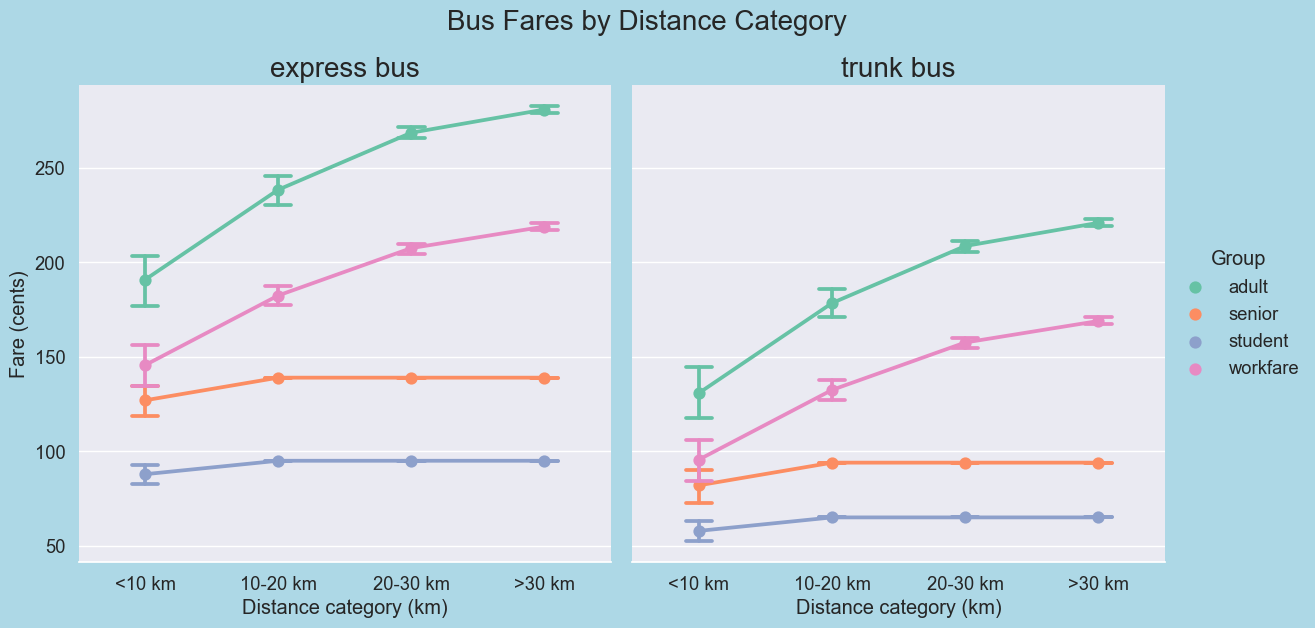

In [16]:
fig = sns.catplot(
    data=df, x="distance_category", y="fare", hue="age_group", col="bus_type",
    capsize=.2, palette="Set2",
    kind="point", height=6, aspect=1,
)


fig.set_xlabels("Distance category (km)")
fig.set_ylabels("Fare (cents)")
fig.despine(left=True)

# Set the title
fig.fig.suptitle('Bus Fares by Distance Category', y=1.05, fontsize=20)

# Edit title of the subplots to be larger
fig.set_titles("{col_name} bus", size=20)

# Edit Legend
fig._legend.set_title('Group')

plt.show()

### Graph 5
Stacked Bar Chart to show concession pass price across different groups

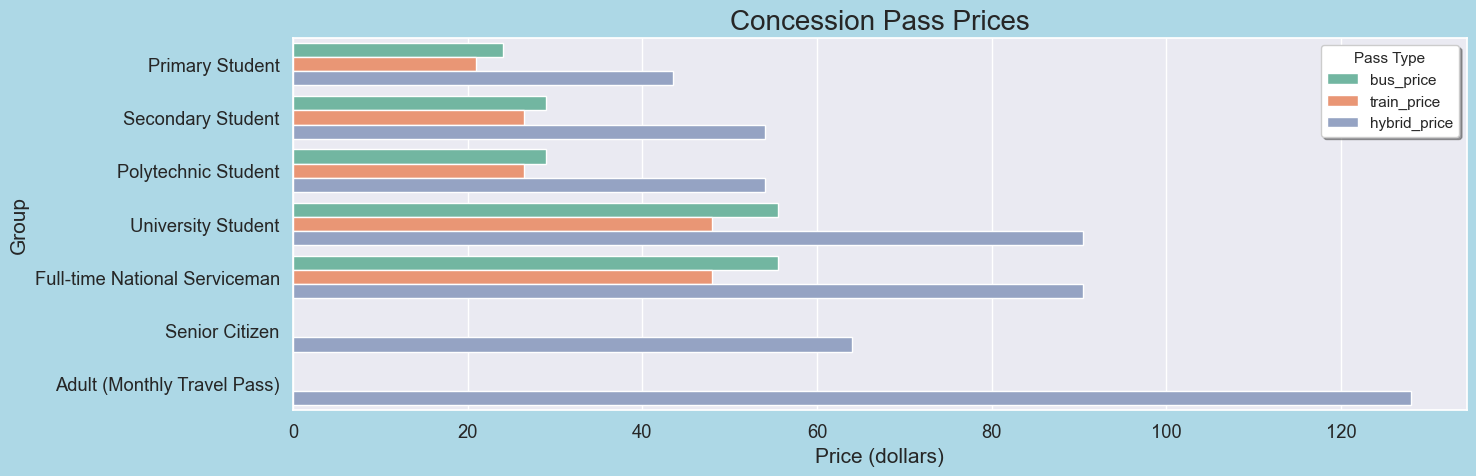

In [17]:
df = concession_pass.copy()

# Plot the stacked bar chart

# Convert from wide to long
df = pd.melt(df, id_vars=['cardholders'], var_name='pass_type', value_name='pass_price')


# Convert to numeric
df['pass_price'] = pd.to_numeric(df['pass_price'])

fig, ax = plt.subplots(figsize=(15,5))

# Plot stacked bar chart horizontally
fig = sns.barplot(
    y="pass_type", x="pass_price", hue="cardholders", data=df, palette="Set2", ax=ax)
# Set the title
fig.set_title('Concession Pass Prices', fontsize=20)
# Set the x-axis label
fig.set_xlabel('Price (dollars)', fontsize=15)
# Set the y-axis label
fig.set_ylabel('Group', fontsize=15)

# Edit the style
sns.set(style="darkgrid", rc={'figure.facecolor':'lightblue'}, font_scale=1.2)

# Edit the legend
ax.legend(loc='upper right', title='Pass Type', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')

plt.tight_layout()
plt.show()

### Graph 6
Bar Chart of fare for each category (EXPRESS, FEEDER etc.) with a horizontal line representing the price of concession pass (assuming 2 * average number of working days in a month 20). This will take up the entire left (quad 2 and 3) => 2 for bus, 3 for MRT/LRT

Box Plot of distribution of fares (quad 1) with table (quad 4)

In [18]:
display(mrt_and_lrt)

time           distance  adult  disability  senior_citizen  \
0    After 7.45am       Up to 3.2 km     99          61              61   
1    After 7.45am    3.3 km - 4.2 km    109          68              68   
2    After 7.45am    4.3 km - 5.2 km    119          75              75   
3    After 7.45am    5.3 km - 6.2 km    129          82              82   
4    After 7.45am    6.3 km - 7.2 km    138          88              88   
..            ...                ...    ...         ...             ...   
73  Before 7.45am  36.3 km - 37.2 km    172          44              44   
74  Before 7.45am  37.3 km - 38.2 km    173          44              44   
75  Before 7.45am  38.3 km - 39.2 km    174          44              44   
76  Before 7.45am  39.3 km - 40.2 km    175          44              44   
77  Before 7.45am       Over 40.2 km    176          44              44   

    student  workfare  
0        44        70  
1        49        78  
2        54        86  
3        59        94  
4        62       101  
..      ...       ...  
73       15       120  
74       15       121  
75       15       122  
76       15       123  
77       15       124  

[78 rows x 7 columns]

In [19]:
# Make bus fare from long to wide
df = bus_fares.copy()

# Convert data from wide to long
df = pd.melt(df, id_vars=['distance', 'distance_category'], var_name='fare_type', value_name='fare')

# Split data from fare_type
df['transport_type'] = df['fare_type'].apply(lambda x: x.split('_')[0])
df['age_group'] = df['fare_type'].apply(lambda x: x.split('_')[1])

# Add column called time
df['time'] = 'After 7.45am'

# Copy of df
df2 = df.copy()
df2['time'] = 'Before 7.45am'

df = pd.concat([df, df2])

# Add MRT/LRT fare to df
df3 = mrt_and_lrt.copy()

# Add distance category
df3['distance_category'] = df3['distance'].apply(distance_categorise)

# Convert data from wide to long
df3 = pd.melt(df3, id_vars=['distance', 'distance_category', 'time'], var_name='fare_type', value_name='fare')

df3['age_group'] = df3['fare_type']
df3['transport_type'] = 'MRT/LRT'

# Reorder to bus column order
df3 = df3[['distance', 'distance_category', 'fare_type', 'fare', 'transport_type', 'age_group', 'time']]

# Concatenate df and df3
df = pd.concat([df, df3])

# Drop fare_type
df = df.drop(columns=['fare_type'])

display(df)
# Standardise age_group
df['age_group'] = df['age_group'].replace('senior', 'senior_citizen')


print(df['age_group'].value_counts())
print(df['transport_type'].value_counts())
print(df['time'].value_counts())

print(df.isnull().sum())






distance distance_category  fare transport_type age_group  \
0         Up to 3.2 km            <10 km   159        express     adult   
1      3.3 km - 4.2 km            <10 km   169        express     adult   
2      4.3 km - 5.2 km            <10 km   179        express     adult   
3      5.3 km - 6.2 km            <10 km   189        express     adult   
4      6.3 km - 7.2 km            <10 km   198        express     adult   
..                 ...               ...   ...            ...       ...   
385  36.3 km - 37.2 km            >30 km   120        MRT/LRT  workfare   
386  37.3 km - 38.2 km            >30 km   121        MRT/LRT  workfare   
387  38.3 km - 39.2 km            >30 km   122        MRT/LRT  workfare   
388  39.3 km - 40.2 km            >30 km   123        MRT/LRT  workfare   
389       Over 40.2 km            >30 km   124        MRT/LRT  workfare   

              time  
0     After 7.45am  
1     After 7.45am  
2     After 7.45am  
3     After 7.45am  
4     After 7.45am  
..             ...  
385  Before 7.45am  
386  Before 7.45am  
387  Before 7.45am  
388  Before 7.45am  
389  Before 7.45am  

[1560 rows x 6 columns]

adult             312
senior_citizen    312
student           312
workfare          312
disability        312
Name: age_group, dtype: int64
express    390
trunk      390
feeder     390
MRT/LRT    390
Name: transport_type, dtype: int64
After 7.45am     780
Before 7.45am    780
Name: time, dtype: int64
distance             0
distance_category    0
fare                 0
transport_type       0
age_group            0
time                 0
dtype: int64


In [20]:
display(concession_pass.columns)

Index(['cardholders', 'Primary Student', 'Secondary Student',
       'Polytechnic Student', 'University Student',
       'Full-time National Serviceman', 'Senior Citizen',
       'Adult (Monthly Travel Pass)'],
      dtype='object')

In [21]:
# Create a plotly subplot
fig = make_subplots(rows=2, cols=2, subplot_titles=("Bus Fares by Distance", "Distribution of Fares", "MRT/LRT Fares by Distance"), specs=[[{}, {"rowspan": 2}], [{}, None]])

# More data cleaning 
x_value = df['distance_category'].unique()
# 40
x_line = [-0.5, 3.5]

new = df.groupby(['distance_category', 'transport_type', 'age_group', 'time'])['fare'].mean().reset_index()

# Sort distance category according to ['<10 km', '10-20 km', '20-30 km', '>30 km']
new['distance_category'] = pd.Categorical(new['distance_category'], categories=['<10 km', '10-20 km', '20-30 km', '>30 km'], ordered=True)
new.sort_values(['distance_category', 'transport_type', 'age_group', 'time'], inplace=True)

# Set fare to int
new['fare'] = new['fare'].astype(int)

# Variables #
express_adult = new[(new['transport_type']=='express') & (new['age_group']=='adult')]['fare']
trunk_adult = new[(new['transport_type']=='trunk') & (new['age_group']=='adult')]['fare']
feeder_adult = new[(new['transport_type']=='feeder') & (new['age_group']=='adult')]['fare']
concession_adult = (concession_pass[concession_pass['cardholders']=='hybrid_price']['Adult (Monthly Travel Pass)'].mean())*1.25
mrt_adult_morning = new[(new['transport_type']=='MRT/LRT') & (new['age_group']=='adult') & (new['time']=='Before 7.45am')]['fare']
mrt_adult_afternoon = new[(new['transport_type']=='MRT/LRT') & (new['age_group']=='adult') & (new['time']=='After 7.45am')]['fare']
express_adult_box = df[(df['transport_type']=='express') & (df['age_group']=='adult')]['fare']
trunk_adult_box = df[(df['transport_type']=='trunk') & (df['age_group']=='adult')]['fare']
feeder_adult_box = df[(df['transport_type']=='feeder') & (df['age_group']=='adult')]['fare']
mrt_adult_box = df[(df['transport_type']=='MRT/LRT') & (df['age_group']=='adult')]['fare']

express_senior = new[(new['transport_type']=='express') & (new['age_group']=='senior_citizen')]['fare']
trunk_senior = new[(new['transport_type']=='trunk') & (new['age_group']=='senior_citizen')]['fare']
feeder_senior = new[(new['transport_type']=='feeder') & (new['age_group']=='senior_citizen')]['fare']
concession_senior = (concession_pass[concession_pass['cardholders']=='hybrid_price']['Senior Citizen'].mean())*1.25
mrt_senior_morning = new[(new['transport_type']=='MRT/LRT') & (new['age_group']=='senior_citizen') & (new['time']=='Before 7.45am')]['fare']
mrt_senior_afternoon = new[(new['transport_type']=='MRT/LRT') & (new['age_group']=='senior_citizen') & (new['time']=='After 7.45am')]['fare']
express_senior_box = df[(df['transport_type']=='express') & (df['age_group']=='senior_citizen')]['fare']
trunk_senior_box = df[(df['transport_type']=='trunk') & (df['age_group']=='senior_citizen')]['fare']
feeder_senior_box = df[(df['transport_type']=='feeder') & (df['age_group']=='senior_citizen')]['fare']
mrt_senior_box = df[(df['transport_type']=='MRT/LRT') & (df['age_group']=='senior_citizen')]['fare']

express_student = new[(new['transport_type']=='express') & (new['age_group']=='student')]['fare']
trunk_student = new[(new['transport_type']=='trunk') & (new['age_group']=='student')]['fare']
feeder_student = new[(new['transport_type']=='feeder') & (new['age_group']=='student')]['fare']
concession_student = (concession_pass[concession_pass['cardholders']=='hybrid_price']['Secondary Student'].mean())*1.25
mrt_student_morning = new[(new['transport_type']=='MRT/LRT') & (new['age_group']=='student') & (new['time']=='Before 7.45am')]['fare']
mrt_student_afternoon = new[(new['transport_type']=='MRT/LRT') & (new['age_group']=='student') & (new['time']=='After 7.45am')]['fare']
express_student_box = df[(df['transport_type']=='express') & (df['age_group']=='student')]['fare']
trunk_student_box = df[(df['transport_type']=='trunk') & (df['age_group']=='student')]['fare']
feeder_student_box = df[(df['transport_type']=='feeder') & (df['age_group']=='student')]['fare']
mrt_student_box = df[(df['transport_type']=='MRT/LRT') & (df['age_group']=='student')]['fare']

express_disabled = new[(new['transport_type']=='express') & (new['age_group']=='disability')]['fare']
trunk_disabled = new[(new['transport_type']=='trunk') & (new['age_group']=='disability')]['fare']
feeder_disabled = new[(new['transport_type']=='feeder') & (new['age_group']=='disability')]['fare']
concession_disabled = (concession_pass[concession_pass['cardholders']=='hybrid_price']['Adult (Monthly Travel Pass)'].mean())*1.25
mrt_disabled_morning = new[(new['transport_type']=='MRT/LRT') & (new['age_group']=='disability') & (new['time']=='Before 7.45am')]['fare']
mrt_disabled_afternoon = new[(new['transport_type']=='MRT/LRT') & (new['age_group']=='disability') & (new['time']=='After 7.45am')]['fare']
express_disabled_box = df[(df['transport_type']=='express') & (df['age_group']=='disability')]['fare']
trunk_disabled_box = df[(df['transport_type']=='trunk') & (df['age_group']=='disability')]['fare']
feeder_disabled_box = df[(df['transport_type']=='feeder') & (df['age_group']=='disability')]['fare']
mrt_disabled_box = df[(df['transport_type']=='MRT/LRT') & (df['age_group']=='disability')]['fare']

# #

# Add the first plot (row=1, col=1) of stacked bar chart
# EXPRESS
fig.add_trace(
    go.Bar(name='EXPRESS', x=x_value, y=express_adult),
    row=1, col=1
)

# TRUNK
fig.add_trace(
    go.Bar(name='TRUNK', x=x_value, y=trunk_adult),
    row=1, col=1
)

# FEEDER
fig.add_trace(
    go.Bar(name='FEEDER', x=x_value, y=feeder_adult),
    row=1, col=1
)

# Add horizontal trace of concession pass prices
fig.add_shape(type='line',
    x0=x_line[0], y0=concession_adult, x1=x_line[1], y1=concession_adult,
    line=dict(color='red', width=2, dash='dash'),
    xref='paper', yref='y',
    row=1, col=1
)

# Add the second plot (row=2, col=1) of bar chart
# MRT/LRT
fig.add_trace(
    go.Bar(name='MRT/LRT', x=x_value, y=mrt_adult_morning),
    row=2, col=1
)

# Add horizontal trace of concession pass prices
fig.add_shape(type='line',
    x0=x_line[0], y0=concession_adult, x1=x_line[1], y1=concession_adult,
    line=dict(color='red', width=2, dash='dash'),
    name='Concession Pass Price',
    row=2, col=1
)

# Annotate the horizontal trace
fig.update_layout(annotations=[
    # Bus
    dict(
        x=1.5,
        y=concession_adult,
        text="Hybrid Concession Pass Daily Price",
        xref="x",
        yref="y",
        showarrow=True,
        arrowhead=7,
        ax=0,
        ay=-90,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color = 'white'
        )
    ),
    # MRT/LRT
    dict(
        x=1.5,
        y=concession_adult,
        text="Hybrid Concession Pass Daily Price",
        xref="x3",
        yref="y3",
        showarrow=True,
        arrowhead=7,
        ax=0,
        ay=-60,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color = 'white'
        )
    )
])

adult_line1 = [dict(type='line', x0=x_line[0], y0=concession_adult, x1=x_line[1], y1=concession_adult, line=dict(color='red', width=2, dash='dash'), xref='paper', yref='y', row=1, col=1)]
adult_line2 = [dict(type='line', x0=x_line[0], y0=concession_adult, x1=x_line[1], y1=concession_adult, line=dict(color='red', width=2, dash='dash'), name='Concession Pass Price', row=2, col=1)]

senior_line1 = [dict(type='line', x0=x_line[0], y0=concession_senior, x1=x_line[1], y1=concession_senior, line=dict(color='red', width=2, dash='dash'), xref='paper', yref='y', row=1, col=1)]
senior_line2 = [dict(type='line', x0=x_line[0], y0=concession_senior, x1=x_line[1], y1=concession_senior, line=dict(color='red', width=2, dash='dash'), name='Concession Pass Price', row=2, col=1)]

student_line1 = [dict(type='line', x0=x_line[0], y0=concession_student, x1=x_line[1], y1=concession_student, line=dict(color='red', width=2, dash='dash'), xref='paper', yref='y', row=1, col=1)]
student_line2 = [dict(type='line', x0=x_line[0], y0=concession_student, x1=x_line[1], y1=concession_student, line=dict(color='red', width=2, dash='dash'), name='Concession Pass Price', row=2, col=1)]

disabled_line1 = [dict(type='line', x0=x_line[0], y0=concession_disabled, x1=x_line[1], y1=concession_disabled, line=dict(color='red', width=2, dash='dash'), xref='paper', yref='y', row=1, col=1)]
disabled_line2 = [dict(type='line', x0=x_line[0], y0=concession_disabled, x1=x_line[1], y1=concession_disabled, line=dict(color='red', width=2, dash='dash'), name='Concession Pass Price', row=2, col=1)]



####################################### Reason for using *1.25 ###############################################

# Assume that 
# - The number of workdays is 20 days per month
# - Travel two times per day (to and back from work)
# - And the each travel time has a transfer (either bus to MRT/LRT or vice versa)
# Hence the total number of trips per month is 20*2*2 = 80 trips per month
# Since the concession pass is in dollars, we need to multiply by 100 to get it in cents
# 100/80 = 1.25
# This means the line shows the average cost per trip for a month if the person purchases the concession pass

##############################################################################################################

# Plot third plot (row=1, col=2) of box plot
# Express
fig.add_trace(
    go.Box(name='EXPRESS', y=express_adult_box, boxpoints='all', jitter=0.5, whiskerwidth=0.2, marker_size=2, line_width=1),
    row=1, col=2
)

# Trunk
fig.add_trace(
    go.Box(name='TRUNK', y=trunk_adult_box, boxpoints='all', jitter=0.5, whiskerwidth=0.2, marker_size=2, line_width=1),
    row=1, col=2
)

# Feeder
fig.add_trace(
    go.Box(name='FEEDER', y=feeder_adult_box, boxpoints='all', jitter=0.5, whiskerwidth=0.2, marker_size=2, line_width=1),
    row=1, col=2
)

# MRT/LRT
fig.add_trace(
    go.Box(name='MRT/LRT', y=mrt_adult_box, boxpoints='all', jitter=0.5, whiskerwidth=0.2, marker_size=2, line_width=1),
    row=1, col=2
)

# Dropdown menu
fig.update_layout(
    updatemenus=[
        # Age Group
        dict(
            buttons=list([
                dict(
                    args=[{'y': [express_adult, trunk_adult, feeder_adult, mrt_adult_morning, express_adult_box, trunk_adult_box, feeder_adult_box, mrt_adult_box]}, [0,1,2,3,4,5,6,7]],
                    label="Adults",
                    method="update"
                ),
                dict(
                    args=[{'y': [express_senior_box, trunk_senior_box, feeder_senior_box, mrt_senior_box]}],
                    label="Seniors",
                    method="update"
                ),
                dict(
                    args=[{'y': [express_disabled_box, trunk_disabled_box, feeder_disabled_box, mrt_disabled_box, express_disabled_box, trunk_disabled_box, feeder_disabled_box, mrt_disabled_box]}, [0,1,2,3,4,5,6,7]],
                    label="Disabled",
                    method="update"
                ),
                dict(
                    args=[{'y': [express_student, trunk_student, feeder_student, mrt_student_morning, express_student_box, trunk_student_box, feeder_student_box, mrt_student_box]}, [0,1,2,3,4,5,6,7]],
                    label="Students",
                    method="update"
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 0},
            showactive=True,
            # Change font color of buttons
            font=dict(color='rgba(0,0,0,1)'),
            x=0,
            xanchor="left",
            y=1.25,
            yanchor="top"
        )
    ]
)

# Styling
fig.update_layout(height=650, width=1150, title_text="Fares for Passengers", template='plotly_dark')

# Make title middle and bold
fig.update_layout(title=dict(
    x=0.5,
    y=0.95,
    font=dict(
        family="Courier New, monospace",
        size=36,
        color="white"
    )
))


# Increase y distance between title and plot
fig.update_layout(title_y=0.98)

# Make legend horizontal
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.18,
    xanchor="right",
    x=1
))

# Move all subplots down
fig.update_layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=200,
        pad=0
    )
)

fig.show()